In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import os
import pandas as pd
import numpy as np
import tqdm
from typing import Tuple
import json 

import cv2
import PIL 

import torch
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils import generate_labels, ImagenetteDataset, get_norm_stats,\
                    get_transforms, train_procedure, get_augmented_transforms, load_model, plot_models
from models import VGG16, VGG11, VGG_tiny, Resnet

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
TRAIN_PATH = 'raw/train'
VAL_PATH = 'raw/val'
TRAIN_LABELS_CSV_PATH = 'raw/train/train_labels.csv'
VAL_LABELS_CSV_PATH = 'raw/val/val_labels.csv'

SAVES_PATH = "saves"

AUGMENT = True

SIZE = 224
batch_size = 16

In [48]:
if 'train_labels.csv' not in os.listdir(TRAIN_PATH):
    generate_labels(TRAIN_PATH, TRAIN_LABELS_CSV_PATH)
if 'val_labels.csv' not in os.listdir(VAL_PATH):
    generate_labels(VAL_PATH, VAL_LABELS_CSV_PATH)

In [5]:
train_labels, val_labels = pd.read_csv(TRAIN_LABELS_CSV_PATH), pd.read_csv(VAL_LABELS_CSV_PATH)
train_labels.head()

,filepath,class_name,class_num
0,raw/train/church/n03028079_10328.JPEG,church,0
1,raw/train/church/n03028079_3583.JPEG,church,0
2,raw/train/church/n03028079_6077.JPEG,church,0
3,raw/train/church/n03028079_3306.JPEG,church,0
4,raw/train/church/n03028079_9356.JPEG,church,0


In [17]:
len(train_labels), len(val_labels)

(9469, 3925)

In [6]:
mean, std = get_norm_stats(TRAIN_LABELS_CSV_PATH)

val_transform = get_transforms(mean, std)
train_transform = get_augmented_transforms(mean, std) if AUGMENT else get_transforms(mean, std)

train_dataset = ImagenetteDataset(TRAIN_LABELS_CSV_PATH, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = ImagenetteDataset(VAL_LABELS_CSV_PATH, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

9


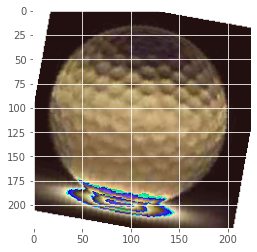

In [21]:
imgs, labels = next(iter(train_dataloader))
transf = T.ToPILImage(mode='RGB')
img = transf(imgs[0])
plt.imshow(img)
print(labels[0].item())

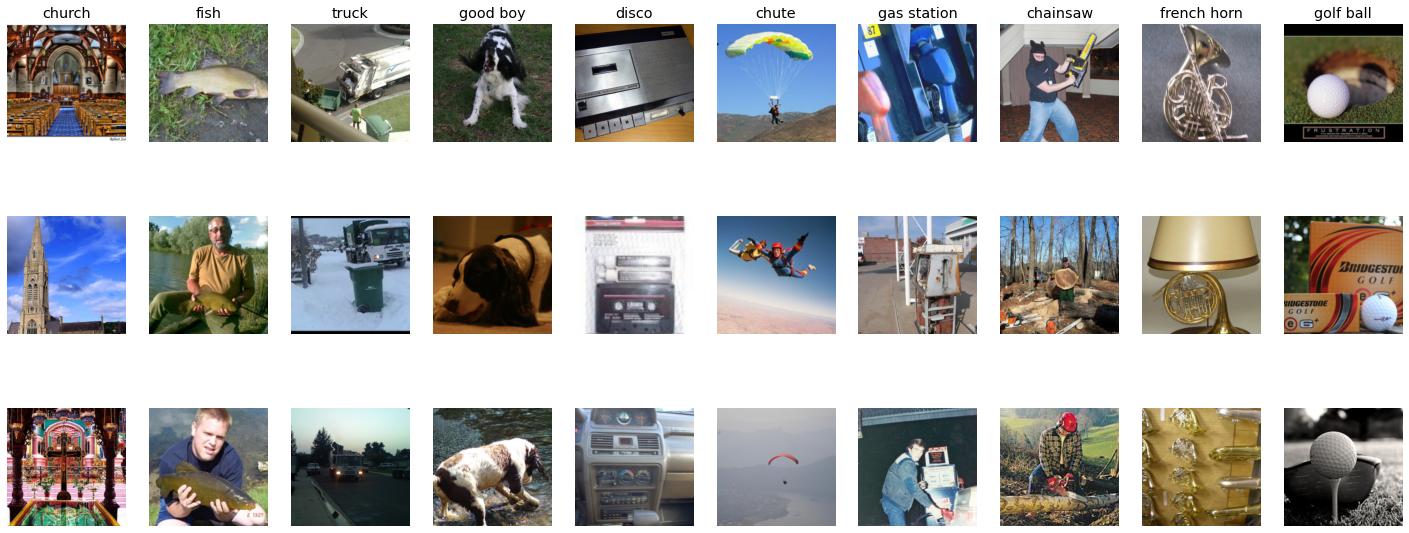

In [22]:
classes = list(train_labels['class_name'].unique())
num_classes = len(classes)
samples_per_class = 3

transform = T.Compose([
    T.Resize(SIZE), 
    T.CenterCrop(SIZE)
])

n_col, n_row = num_classes, samples_per_class
plt.figure(figsize=(25, 10))
for y, label in enumerate(classes):
    ids = np.random.choice(train_labels.loc[train_labels['class_name']==label].index, samples_per_class)
    for i, idx in enumerate(ids):
        img = PIL.Image.open(train_labels.iloc[ids[i]]['filepath'])
        img = transform(img)
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(label)
    

In [7]:
class_names = [name for name in os.listdir(TRAIN_PATH) if name not in ['.ipynb_checkpoints', 'train_labels.csv']]

In [59]:
class_names

['church',
 'fish',
 'truck',
 'good boy',
 'disco',
 'chute',
 'gas station',
 'chainsaw',
 'french horn',
 'golf ball']

In [11]:
if 'model' in locals():
    del model
    
N_EPOCHS = 40
RESUME_TRAINING = True

model_name = 'resnet34_aug'
epoch = 0

model = Resnet(num_layers=34)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)

if RESUME_TRAINING:
    epoch = load_model(model, optimizer, os.path.join(SAVES_PATH, f'ckpts3/{model_name}_model.pt'))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-7)
model.to(device);

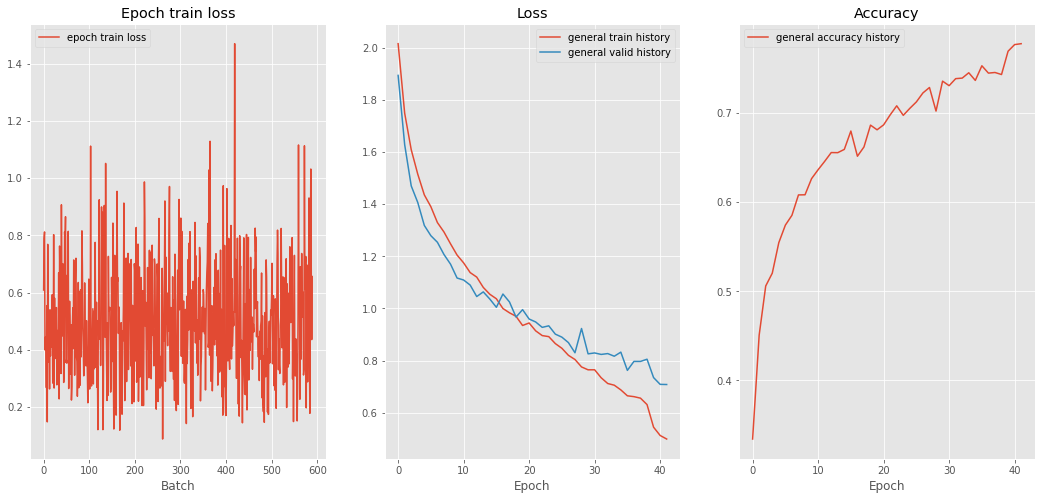

In [12]:
train_procedure(n_epochs=N_EPOCHS, model=model, train_iterator=train_dataloader, 
                val_iterator=val_dataloader, optimizer=optimizer,
                criterion=loss, saves_path=SAVES_PATH, start_epoch=epoch, 
                device=device, scheduler=scheduler, model_name=model_name)

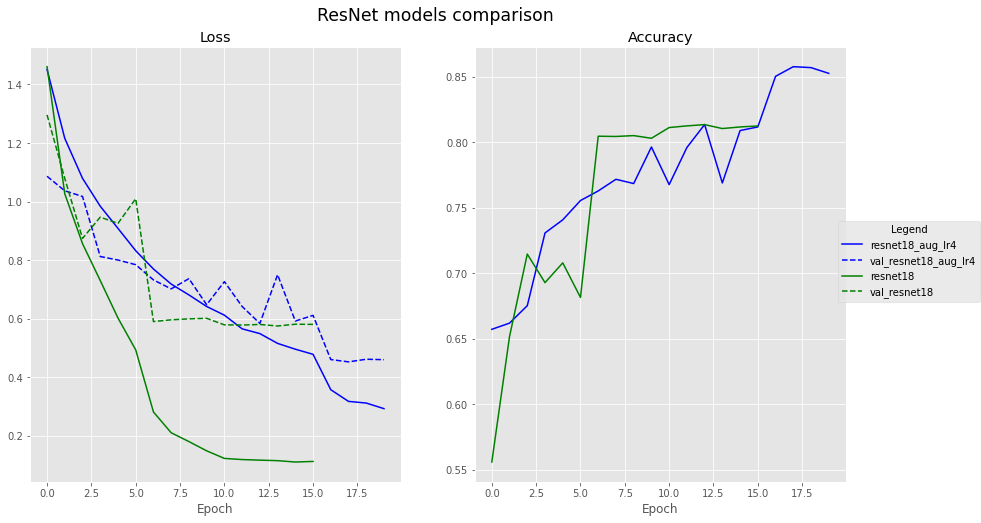

In [152]:
plot_models(['logs_resnet18_aug_lr4.json','logs_resnet18.json'], title='ResNet models comparison')

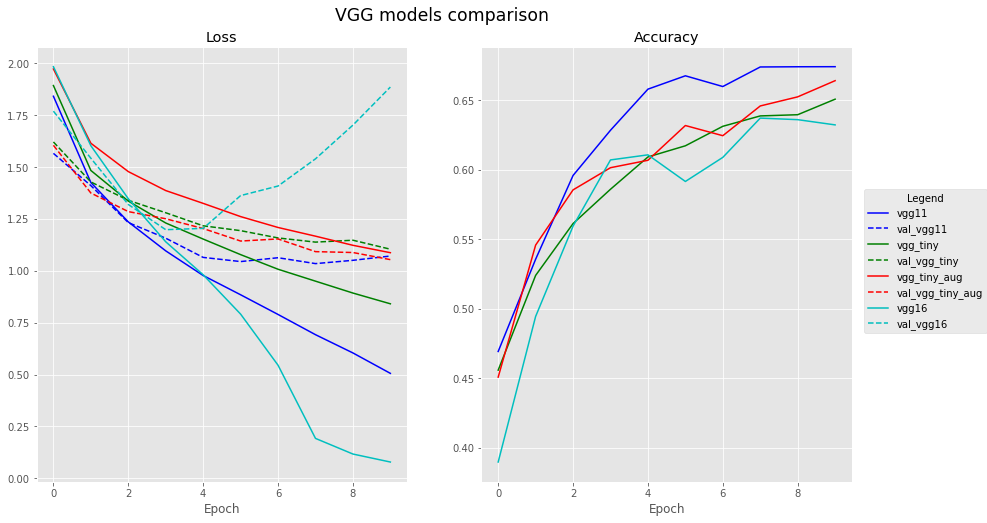

In [150]:
plot_models(['logs_vgg11.json', 'logs_vgg_tiny.json', 'logs_vgg_tiny_aug.json','logs_vgg16.json'], title='VGG models comparison')

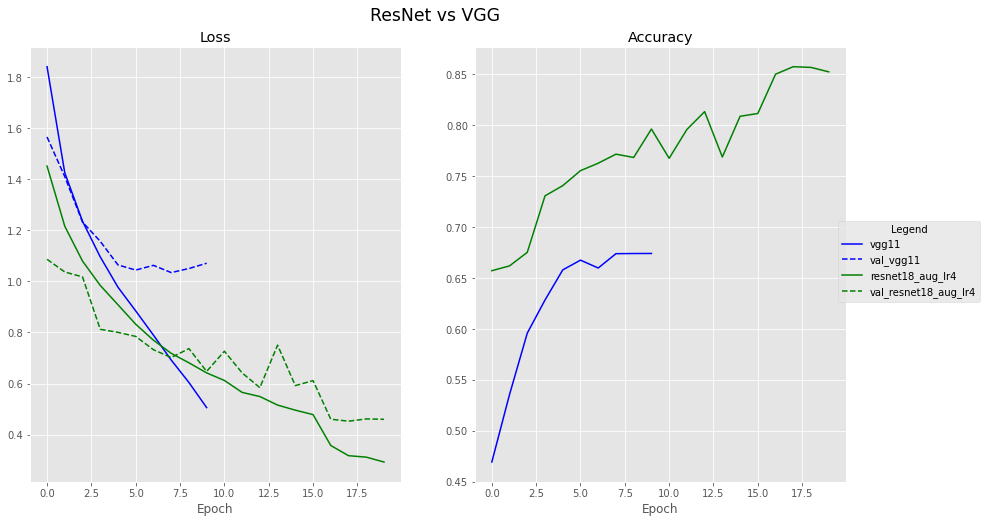

In [153]:
plot_models(['logs_vgg11.json','logs_resnet18_aug_lr4.json' ], title='ResNet vs VGG')

In [ ]:
# TODO  
# mistakes visualization
# параметры в логи

In [22]:
if 'model' in locals():
    del model 
    
model = Resnet18()
ckpt_path = "saves/ckpts2/resnet18_aug_lr4_model.pt"
    
checkpoint = torch.load(ckpt_path, device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

model.eval()

class_shot = np.zeros(10)
class_cnt = np.zeros(10)
predictions = np.array([0])
labels_true = np.array([0])
mistake_imgs = {i: [] for i in range(10)}
mistake_preds = {i: [] for i in range(10)}
mistake_labels = {i: [] for i in range(10)}
with torch.no_grad():
    for i, (imgs, labels) in enumerate(val_dataloader):
        imgs = imgs.to(device)
        labels = labels.numpy().astype(int)
        predictions_batch = model(imgs).argmax(axis=1).detach().cpu().numpy().astype(int)
        
        mistake_ids = np.where(labels != predictions_batch)[0]
        if len(mistake_ids) > 0:
            for ind in mistake_ids:
                if len(mistake_imgs[labels[ind]]) < 5:
                    mistake_imgs[labels[ind]].append(imgs[ind].clone().detach().cpu())
                    mistake_labels[labels[ind]].append(labels[ind])
                    mistake_preds[labels[ind]].append(predictions_batch[ind])
        for ind, label in enumerate(labels):
            if label == predictions_batch[ind]:
                class_shot[label] += 1
            class_cnt[label] += 1
            
        predictions = np.concatenate((predictions, predictions_batch), axis=None)
        labels_true = np.concatenate((labels_true, labels), axis=None)
        
predictions, labels_true = predictions[1:], labels_true[1:]
predictions.shape, labels_true.shape, len(mistake_imgs[0]), len(mistake_labels[0]), len(mistake_preds[0])

((3925,), (3925,), 5, 5, 5)

In [23]:
accuracy_score(labels_true, predictions)

0.09503184713375797

In [262]:
for ind, label in enumerate(class_shot):
    print(f'accuracy of class {ind}: {label / class_cnt[ind]}')

accuracy of class 0: 0.7828162291169452
accuracy of class 1: 0.9189873417721519
accuracy of class 2: 0.8627450980392157
accuracy of class 3: 0.9431524547803618
accuracy of class 4: 0.8974358974358975
accuracy of class 5: 0.8920308483290489
accuracy of class 6: 0.8557457212713936
accuracy of class 7: 0.849624060150376
accuracy of class 8: 0.8121827411167513
accuracy of class 9: 0.7642487046632125


In [263]:
confusion_matrix(labels_true, predictions)

array([[328,   3,  16,   2,   7,  31,  16,   1,   4,  11],
       [  2, 363,   1,   4,   3,   3,   2,   6,   0,  11],
       [ 23,   0, 308,   0,   2,   9,   2,   4,   1,   8],
       [  2,   2,   4, 365,   1,   1,   2,   4,   0,   6],
       [  1,   0,   5,   3, 350,   5,   5,   5,   2,  14],
       [ 14,   2,   3,   2,   2, 347,   3,   0,   3,  13],
       [ 16,   2,   9,   3,  10,   7, 350,   6,   2,   4],
       [  3,   4,   5,   7,  19,   4,  10, 339,   6,   2],
       [ 17,   7,  12,   4,   3,   4,   3,   7, 320,  17],
       [ 12,   6,  19,  10,  12,  13,   2,   8,   9, 295]])

In [256]:
imgs, labels = next(iter(val_dataloader))


/tmp/ipykernel_31682/2531955048.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[j, i].imshow(renorm(torch.tensor(images[j])))


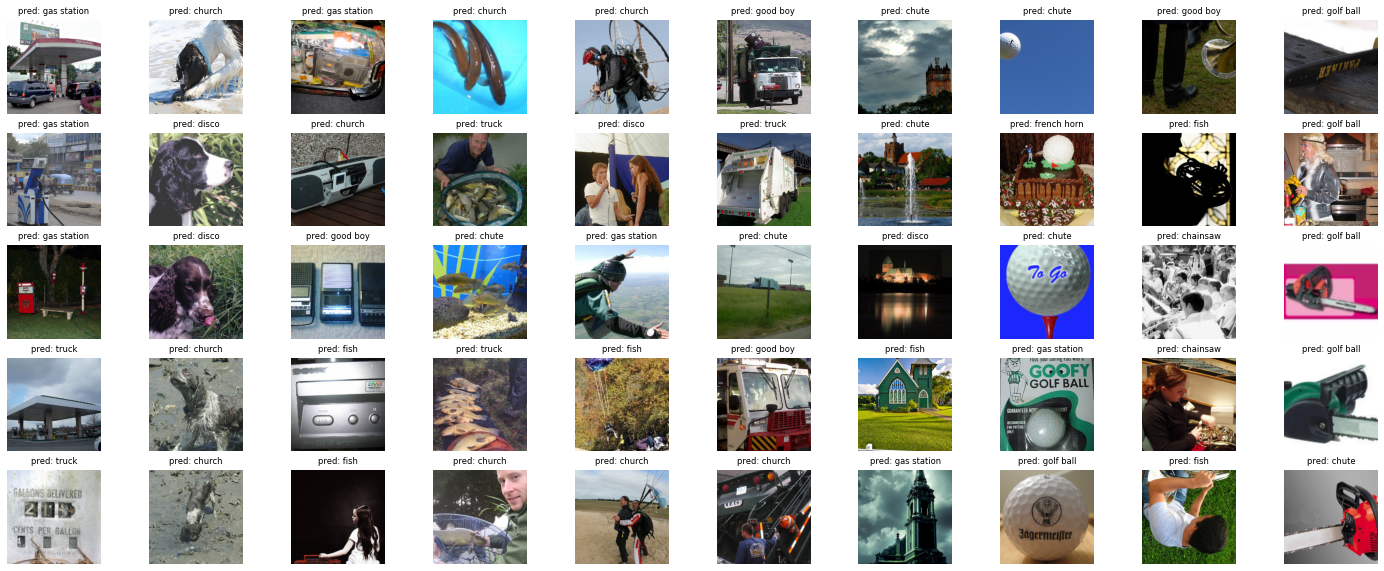

In [302]:
renorm = T.Compose(
    [
     T.Normalize(mean=(0,0,0), std = 1. / np.array(std)),
    T.Normalize(mean=-np.array(mean), std=(1., 1., 1.)), 
    T.ToPILImage(mode='RGB')
    ] 
    )

fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(25, 10))
for i in range(10):
    labels= mistake_labels[i]
    images = mistake_imgs[i]
    preds = mistake_preds[i]
    for j in range(5):
        ax[j, i].imshow(renorm(torch.tensor(images[j])))
        ax[j, i].set_title(f'pred: {new_class_names[preds[j]]}', fontsize='small')
        ax[j, i].axis('off')
    
plt.show();

In [99]:
def check_parameters():
    resnet18 = Resnet(out_dim=1000)
    my_18_param_cnt = resnet18.count_parameters()
    resnet18_torch = models.resnet18(pretrained=False)
    torch_18_param_cnt = sum(p.numel() for name, p in resnet18.named_parameters() if p.requires_grad)
    print(f'torch resnet18 param: {torch_18_param_cnt}, custom resnet18 param: {my_18_param_cnt}')
    del resnet18
    del resnet18_torch
    resnet34 = Resnet(num_layers=34, out_dim=1000)
    my_34_param_cnt = resnet34.count_parameters()
    resnet34_torch = models.resnet34(pretrained=False)
    torch_34_param_cnt = sum(p.numel() for name, p in resnet34_torch.named_parameters() if p.requires_grad)
    print(f'torch resnet34 param: {torch_34_param_cnt}, custom resnet34 param: {my_34_param_cnt}')
    del resnet34
    del resnet34_torch
    

In [100]:
check_parameters()

torch resnet18 param: 11689512, custom resnet18 param: 11689512
torch resnet34 param: 21797672, custom resnet34 param: 21797672
